# Description du problème 

## Contexte 
Le marché américain des actions est l'un des plus liquides au monde, et fournit de nombreuses opportunités d'investissement. Les deux dernières heures de la session, entre 14H et 16H, sont les plus liquides de toutes. <br>
<br>
Cette période est la préférée pour acheter ou vendre une grande quantité d'actifs, car les conditions de marché sont alors meilleures (coûts de transaction plus bas, volatilité moindre, …). C'est pourquoi estimer à l'avance le comportement d'un actif sur cette période permet d'optimiser l'ensemble de son portefeuille. <br>
<br>

## But 
Le but de ce challenge est d'estimer la direction du prix d'une action durant les deux dernières heures de trading, connaissant le comportement du début de la journée. <br>
<br>
Pour éviter le bruit habituel des mouvements financiers, nous ne considérons que trois directions : <br>

- une baisse franche du prix ;
- une évolution mineure, quelque soit le sens ;
- une hausse franche du prix.

## Description des données
Nous fournissons les évolutions de prix (rendements) avec une granularité de 5 minutes, ce qui aboutit à 53 valeurs sur ces 4,5 heures, pour chaque jour et action. <br>
<br>
Comme ces rendements sont faibles, nous les exprimons en point de base (bps), c'est-à-dire $ \space \frac{P_{t+5 mn} - P_t}{P_t} . 10^{-4}$. <br>
<br>
Colonnes : <br>

- 'ID', l'identifiant unique de cette ligne ;
- 'day', l'identifiant du jour concerné (non unique dans le jeu de données) ;
- 'equity', l'identifiant de l'action concernée (non unique dans le jeu de donnée) ;
- '$r_0$' = $ \space \frac{P_{9:35} - P_{9:30}}{P_{9:30}} . 10^{-4}$ 
- ... 
- '$r_{52}$' = $ \space \frac{P_{14:00} - P_{13:55}}{P_{13:55}} . 10^{-4}$ 

Pour réduire la difficulté de la tâche, la prédiction se limite à estimer la direction du rendement des deux dernières heures, groupée en 3 cas : <br>

- $-1$ si $ \space \frac{P_{16 \text{PM}} - P_{14 \text{PM}}}{P_{14 \text{PM}}} . 10^{-4}$ est inférieur à $-25 \text{bps}$; 
- $0$ si ce rendement est compris entre $-25 \text{bps}$ et $25 \text{bps}$;
- $1$ s'il est supérieur à $25 \text{bps}$ 

Le fichier de prédiction comprend les colonnes :

- 'ID', l'identifiant unique la ligne prédite ;
- 'reod', la classe estimée du rendement de la fin de session, incluse dans {$-1,0,1$}

Il est à noter que pour éviter toute fuite d'information, les jeux d'entrainement et de test ne comportent pas d'actions ni de jours en commun. Les actions des deux datasets ont cependant exactement les mêmes caractéristiques financières, afin de pouvoir prédire leurs comportements. Néanmoins, les deux périodes concernées sont totalement différentes, afin de correspondre à un vrai travail de prédiction, sur des données réelles d'un monde dont les caractéristiques peuvent changer.

In [16]:
# Imports 

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns  
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, StackingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier


In [17]:
dossier = '/Users/augustincablant/Desktop/Kaggle/CFM/'

X_train = pd.read_csv(dossier + 'input_training.csv')
y_train = pd.read_csv('output_training_gmEd6Zt.csv')

df_train = pd.merge(X_train, y_train, on ='ID', how = 'inner')
df = df_train.copy()
evol = X_train.drop(['ID','equity','day'], axis=1).columns.to_list()

# EDA

In [6]:
print(X_train.shape)
X_train.head()

(843299, 56)


,ID,day,equity,r0,r1,r2,r3,r4,r5,r6,...,r43,r44,r45,r46,r47,r48,r49,r50,r51,r52
0,0,249,1488,0.00,NaN,NaN,NaN,0.00,NaN,NaN,...,0.00,0.00,NaN,0.00,NaN,0.00,NaN,NaN,NaN,0.00
1,1,272,107,-9.76,0.00,-12.21,46.44,34.08,0.00,41.24,...,-4.83,-16.92,-4.84,4.84,0.00,7.26,-9.68,-19.38,9.71,26.68
2,2,323,1063,49.85,0.00,0.00,-26.64,-23.66,-22.14,49.12,...,-6.37,1.59,6.37,-49.32,-9.59,-6.40,22.41,-6.39,7.99,15.96
3,3,302,513,0.00,NaN,0.00,0.00,0.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN
4,4,123,1465,-123.84,-115.18,-26.44,0.00,42.42,10.56,0.00,...,-5.36,-21.44,-21.48,10.78,-21.55,-5.40,-10.81,5.41,-32.47,43.43


In [5]:
y_train.head()

,ID,reod
0,0,0
1,1,0
2,2,-1
3,3,0
4,4,-1


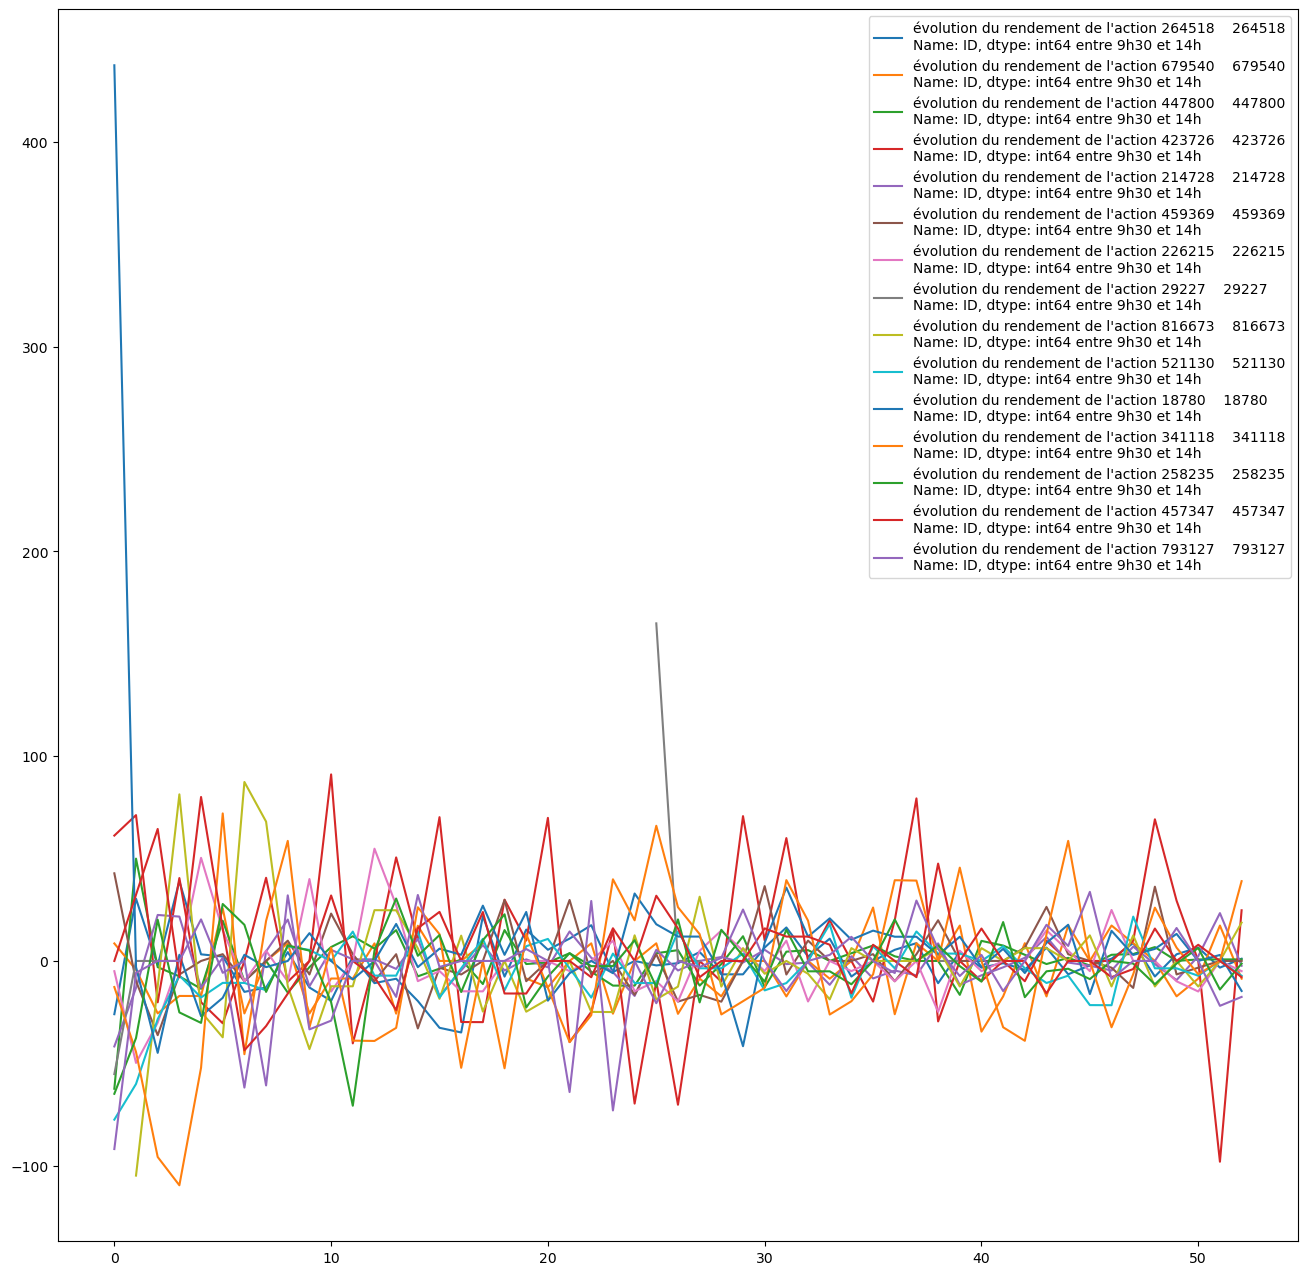

In [21]:
plt.figure(figsize = (16,16))
for _ in range(15): 

    df_plot = X_train.drop(['day','equity'], axis=1).sample(1)
    ID = df_plot['ID']
    evol = df_plot.drop('ID', axis=1)
    column_names = evol.columns.to_list()
    x_axis = list(range(len(column_names)))
    values = list(evol.values[0])
    plt.plot(x_axis,values,label= f"évolution du rendement de l'action {ID} entre 9h30 et 14h")
    plt.legend()

plt.show()


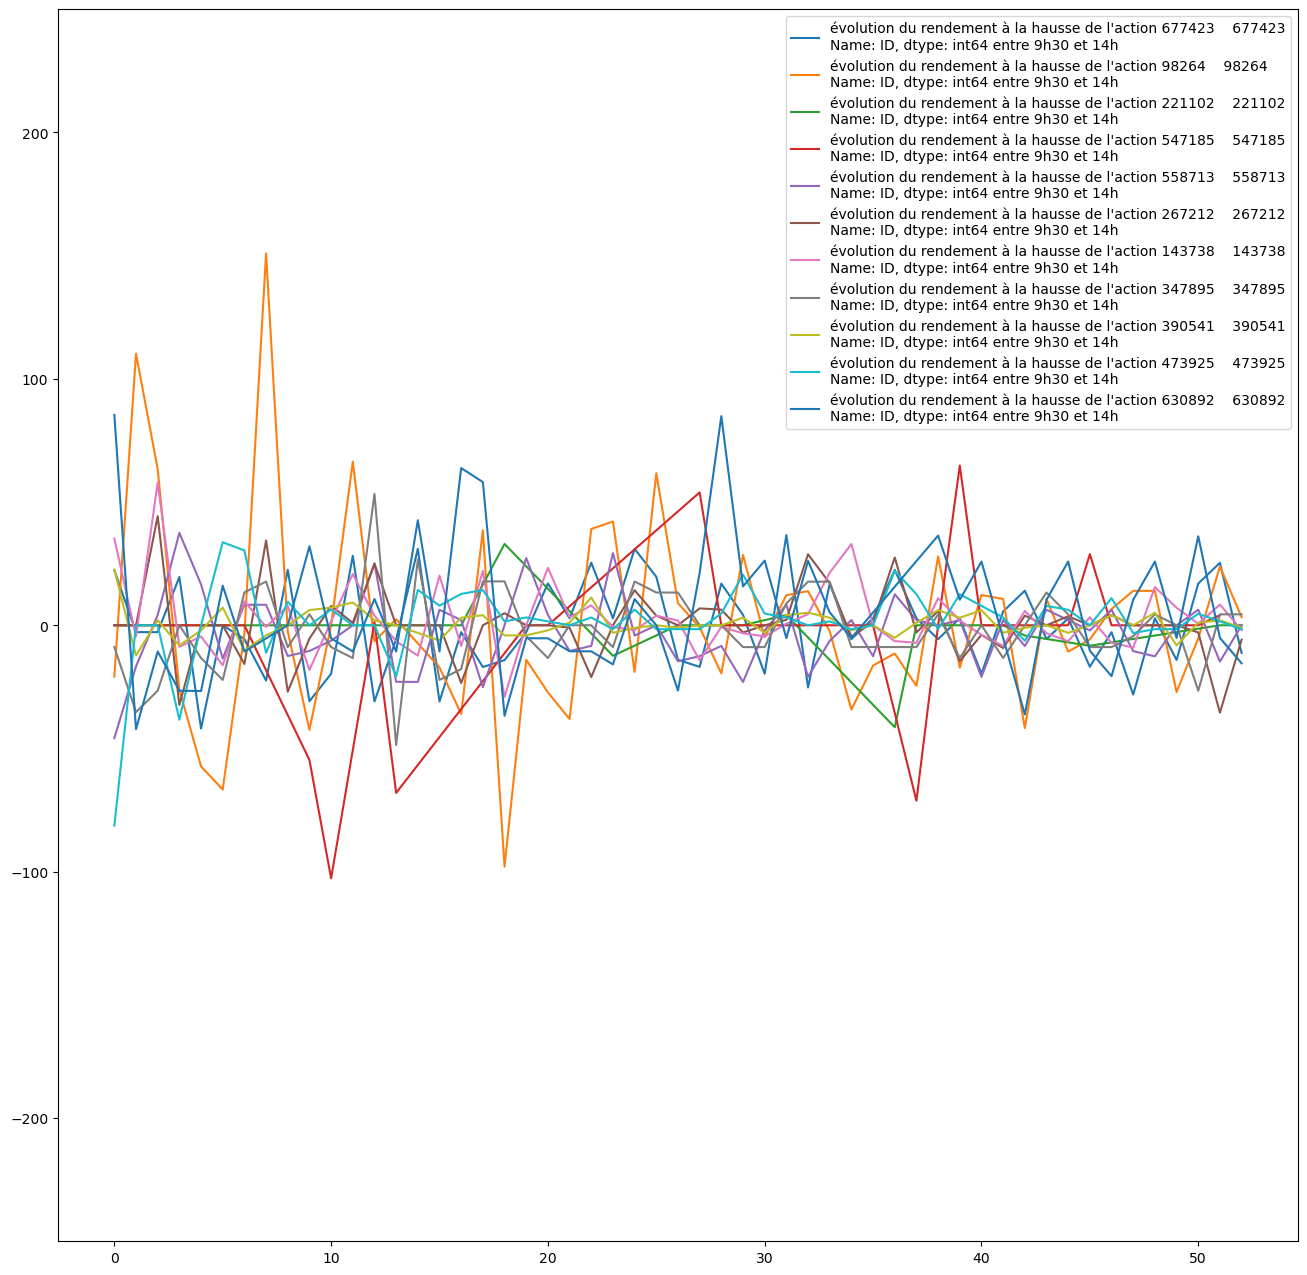

In [27]:
plt.figure(figsize = (16,16))
for _ in range(11): 
    sub_df = df_train[df_train['reod']==1]
    df_plot = sub_df.drop(['reod','day','equity'], axis=1).sample(1)
    ID = df_plot['ID']
    evol = df_plot.drop('ID', axis=1)
    column_names = evol.columns.to_list()
    x_axis = list(range(len(column_names)))
    values = list(evol.values[0])
    sns.lineplot(x = x_axis,y=values,label= f"évolution du rendement à la hausse de l'action {ID} entre 9h30 et 14h")
    plt.ylim(-250, 250)
    plt.legend()

plt.show()

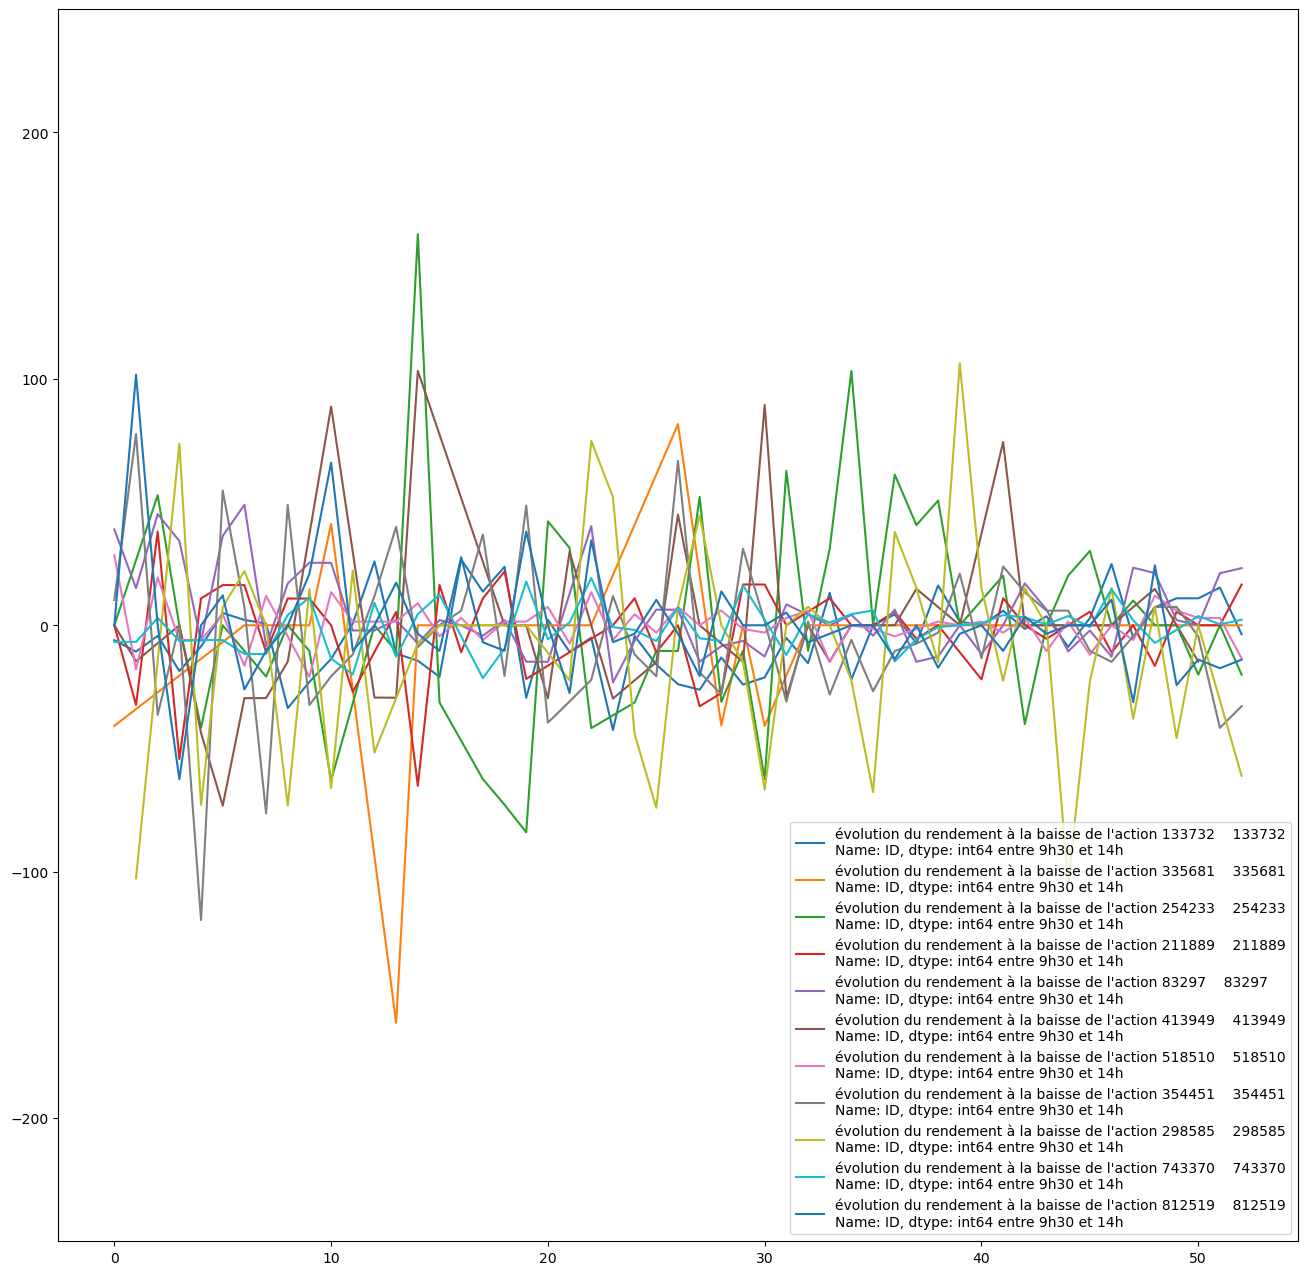

In [28]:
plt.figure(figsize = (16,16))
for _ in range(11): 
    sub_df = df_train[df_train['reod']==-1]
    df_plot = sub_df.drop(['reod','day','equity'], axis=1).sample(1)
    ID = df_plot['ID']
    evol = df_plot.drop('ID', axis=1)
    column_names = evol.columns.to_list()
    x_axis = list(range(len(column_names)))
    values = list(evol.values[0])
    sns.lineplot(x = x_axis,y=values,label= f"évolution du rendement à la baisse de l'action {ID} entre 9h30 et 14h")
    plt.ylim(-250, 250)
    plt.legend()

plt.show()

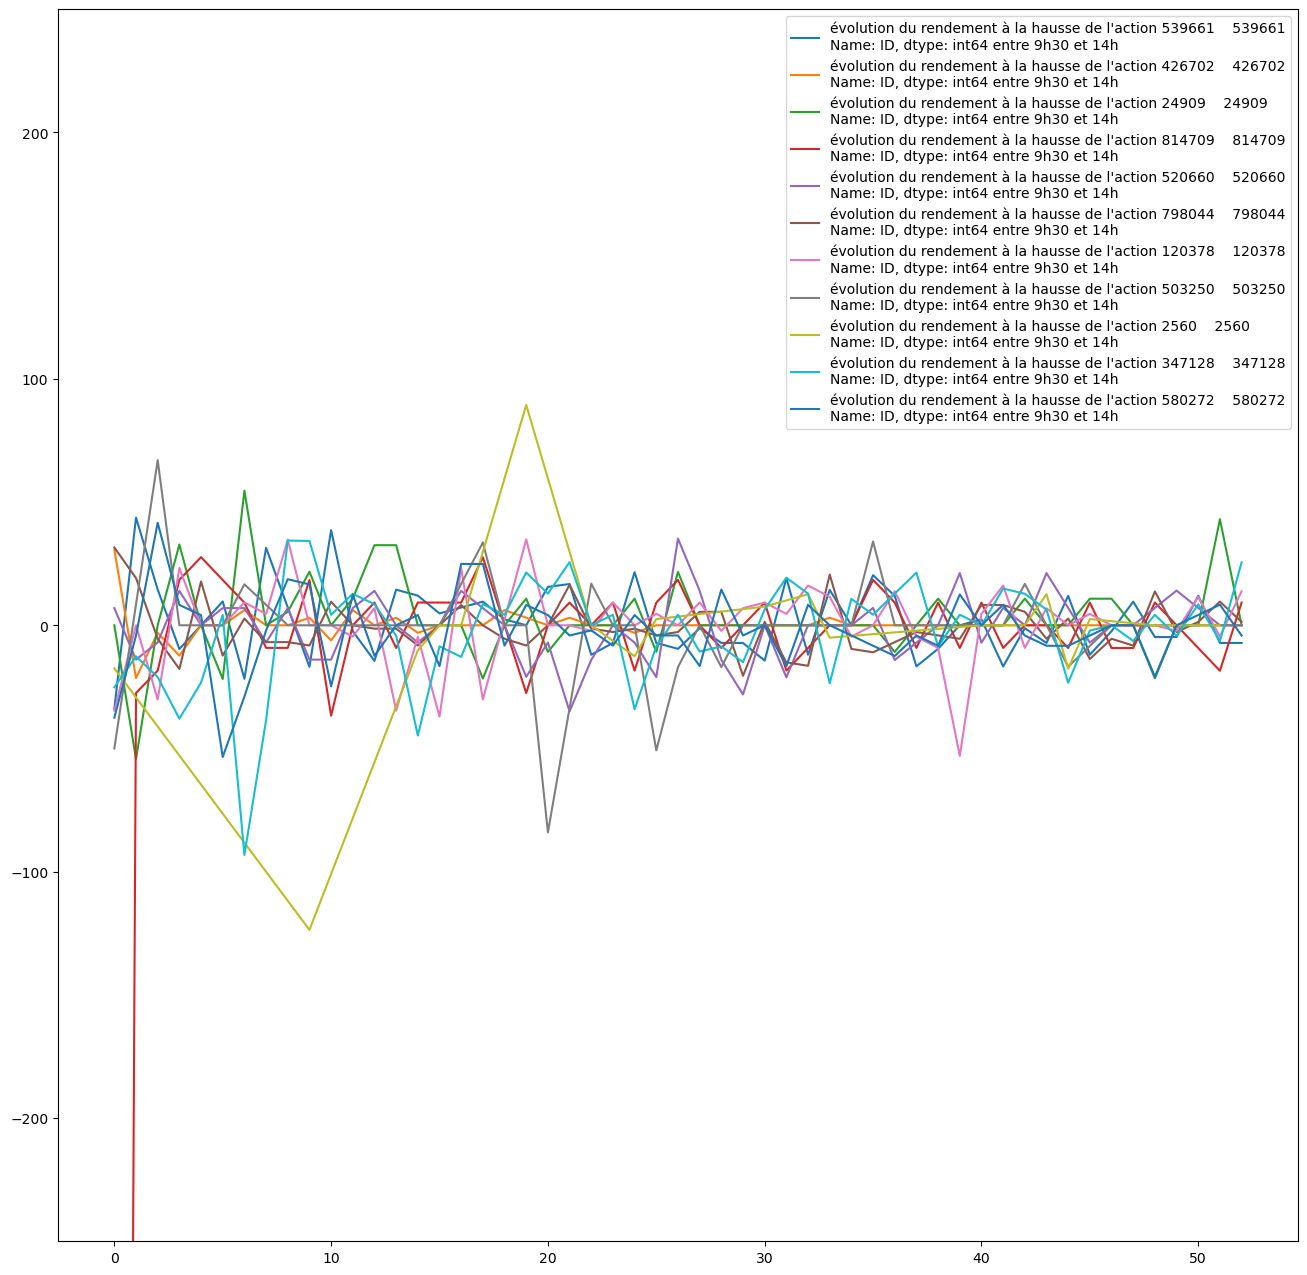

In [30]:
plt.figure(figsize = (16,16))
for _ in range(11): 
    sub_df = df_train[df_train['reod']==0]
    df_plot = sub_df.drop(['reod','day','equity'], axis=1).sample(1)
    ID = df_plot['ID']
    evol = df_plot.drop('ID', axis=1)
    column_names = evol.columns.to_list()
    x_axis = list(range(len(column_names)))
    values = list(evol.values[0])
    sns.lineplot(x = x_axis,y=values,label= f"évolution du rendement à la hausse de l'action {ID} entre 9h30 et 14h")
    plt.ylim(-250, 250)
    plt.legend()

plt.show()

On a l'impression que les actions catégorisée '-1' ont subies plus de fluctuations au cours de la matinée. 

In [45]:
df['fluctuation'] = 0
for col in X_train.drop(['ID','equity','day'], axis=1).columns.to_list():
    df['fluctuation'] += np.abs(df[col])

print("La moyenne de la somme des fluctuations pour les actions à la hausse vaut ", df[df['reod']==1]['fluctuation'].mean() )
print("La moyenne de la somme des fluctuations pour les actions à la baisse vaut ", df[df['reod']==-1]['fluctuation'].mean() )

print("L'écart-type de la somme des fluctuations pour les actions à la hausse vaut ", df[df['reod']==1]['fluctuation'].std() )
print("L'écart-type  de la somme des fluctuations pour les actions à la baisse vaut ", df[df['reod']==-1]['fluctuation'].std() )

print("La valeur minimale de la somme des fluctuations pour les actions à la hausse vaut ", df[df['reod']==1]['fluctuation'].min() )
print("La valeur minimale de la somme des fluctuations pour les actions à la baisse vaut ", df[df['reod']==-1]['fluctuation'].min() )

print("La valeur maximale de la somme des fluctuations pour les actions à la hausse vaut ", df[df['reod']==1]['fluctuation'].max() )
print("La valeur maximale de la somme des fluctuations pour les actions à la baisse vaut ", df[df['reod']==-1]['fluctuation'].max() )

La moyenne de la somme des fluctuations pour les actions à la hausse vaut  1788.1623661573014
La moyenne de la somme des fluctuations pour les actions à la baisse vaut  1976.2942240761272
L'écart-type de la somme des fluctuations pour les actions à la hausse vaut  186639.57671438393
L'écart-type  de la somme des fluctuations pour les actions à la baisse vaut  380591.36758155446
La valeur minimale de la somme des fluctuations pour les actions à la hausse vaut  0.0
La valeur minimale de la somme des fluctuations pour les actions à la baisse vaut  9.31
La valeur maximale de la somme des fluctuations pour les actions à la hausse vaut  48211291.19999999
La valeur maximale de la somme des fluctuations pour les actions à la baisse vaut  164090384.37


In [40]:
#pd.DataFrame([X_train[evol].mean(axis=0)[:,1], X_train[evol].std(axis=0)[:,1], X_train[evol].min(axis=0)[:,1], X_train[evol].max(axis=0)[:,1]], 
             #columns = ['mean', 'std', 'max','min'])

#pd.merge(pd.DataFrame(X_train[evol].mean(axis=0)), , on 

df_stat = pd.DataFrame([df_train[df_train['reod']==1][evol].std(axis=0),df_train[df_train['reod']==-1][evol].std(axis=0),
                       df_train[df_train['reod']==0][evol].std(axis=0), 
                       df_train[df_train['reod']==1][evol].mean(axis=0),df_train[df_train['reod']==-1][evol].mean(axis=0),
                       df_train[df_train['reod']==0][evol].mean(axis=0),
                       df_train[df_train['reod']==1][evol].min(axis=0),df_train[df_train['reod']==-1][evol].min(axis=0),
                       df_train[df_train['reod']==0][evol].min(axis=0),
                       df_train[df_train['reod']==1][evol].max(axis=0),df_train[df_train['reod']==-1][evol].max(axis=0),
                       df_train[df_train['reod']==0][evol].max(axis=0),
                       ]).reset_index()
df_stat['stat'] = ""

df_stat['stat'][0:3] = "std"
df_stat['index'][0] = 'reod==1'
df_stat['index'][1] = 'reod==-1'
df_stat['index'][2] = 'reod==0'

df_stat['stat'][3:6] = "mean"
df_stat['index'][3] = 'reod==1'
df_stat['index'][4] = 'reod==-1'
df_stat['index'][5] = 'reod==0'

df_stat['stat'][6:9] = "min"
df_stat['index'][6] = 'reod==1'
df_stat['index'][7] = 'reod==-1'
df_stat['index'][8] = 'reod==0'

df_stat['stat'][9:12] = "max"
df_stat['index'][9] = 'reod==1'
df_stat['index'][10] = 'reod==-1'
df_stat['index'][11] = 'reod==0'

df_stat = df_stat.T
last_row = df_stat.iloc[-1]
df_stat = df_stat.iloc[:-1]
df_stat = pd.DataFrame([last_row]).append(df_stat, ignore_index=False)

df_stat

/var/folders/bt/r1dg46ys21lb57m4n4x11m6c0000gn/T/ipykernel_5438/971126471.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stat['stat'][0:3] = "std"
/var/folders/bt/r1dg46ys21lb57m4n4x11m6c0000gn/T/ipykernel_5438/971126471.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stat['index'][0] = 'reod==1'
/var/folders/bt/r1dg46ys21lb57m4n4x11m6c0000gn/T/ipykernel_5438/971126471.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

,0,1,2,3,4,5,6,7,8,9,10,11
stat,std,std,std,mean,mean,mean,min,min,min,max,max,max
index,reod==1,reod==-1,reod==0,reod==1,reod==-1,reod==0,reod==1,reod==-1,reod==0,reod==1,reod==-1,reod==0
r0,136064.062773,343378.635518,901061.119081,492.581656,860.315142,3526.701215,-9967.67,-9937.0,-9851.5,48210000.0,164090000.0,431070000.0
r1,81.469414,80.173699,186808.624495,-0.097009,-1.070241,508.762431,-9973.54,-9945.94,-9971.65,2804.65,2578.71,75160000.0
r2,100965.716463,59.825221,8552.75824,211.782769,-0.550835,15.774531,-4823.74,-1890.36,-2448.61,47890000.0,3557.05,4530000.0
r3,53.04462,53.874186,28968.755014,-1.37394,-1.08426,53.528767,-1365.81,-1949.69,-1190.48,1505.81,3620.69,15450000.0
r4,48.011741,47.832467,38.933181,-0.385237,-0.160674,-0.125679,-1272.73,-1390.13,-1331.76,1760.0,1554.62,2327.87
r5,44.232144,44.324434,36.621442,-0.007713,0.642181,0.217209,-1266.67,-1632.29,-1538.46,2134.15,2215.87,2396.69
r6,42.632628,43.219118,36.769947,-0.396086,-0.623628,0.012453,-864.03,-1559.32,-1373.63,1307.69,1500.0,2343.75
r7,41.195464,40.505419,33.812274,-1.800077,-0.775807,-1.062545,-2066.67,-1133.33,-1242.6,2733.81,2149.53,1217.28


<AxesSubplot:>

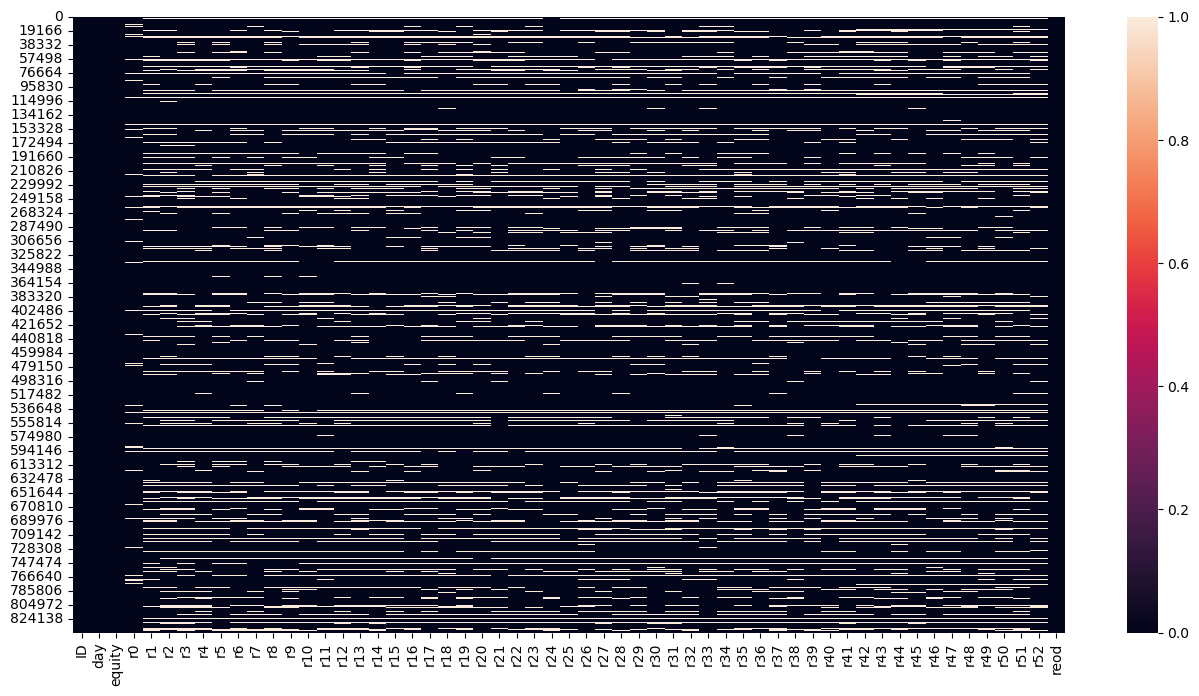

In [81]:
plt.figure(figsize = (16,8))
sns.heatmap(df.isna(), cbar = True)

In [8]:
df.head(10)

,ID,day,equity,r0,r1,r2,r3,r4,r5,r6,...,r44,r45,r46,r47,r48,r49,r50,r51,r52,reod
0,0,249,1488,0.00,NaN,NaN,NaN,0.00,NaN,NaN,...,0.00,NaN,0.00,NaN,0.00,NaN,NaN,NaN,0.00,0
1,1,272,107,-9.76,0.00,-12.21,46.44,34.08,0.00,41.24,...,-16.92,-4.84,4.84,0.00,7.26,-9.68,-19.38,9.71,26.68,0
2,2,323,1063,49.85,0.00,0.00,-26.64,-23.66,-22.14,49.12,...,1.59,6.37,-49.32,-9.59,-6.40,22.41,-6.39,7.99,15.96,-1
3,3,302,513,0.00,NaN,0.00,0.00,0.00,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,0
4,4,123,1465,-123.84,-115.18,-26.44,0.00,42.42,10.56,0.00,...,-21.44,-21.48,10.78,-21.55,-5.40,-10.81,5.41,-32.47,43.43,-1
5,5,343,1279,-26.91,4.76,9.52,-5.55,-7.14,-1.59,-7.14,...,0.80,-3.19,3.99,-3.19,-4.79,-5.59,6.39,-6.38,-5.59,0
6,6,212,185,0.00,-30.67,4.40,-13.19,13.20,26.37,4.38,...,0.00,6.62,13.23,0.00,0.00,4.40,13.20,-4.40,4.40,-1
7,7,239,780,110.26,-33.25,-7.81,36.55,-29.47,3.28,17.21,...,-23.96,7.80,8.62,2.87,-6.97,-12.72,-9.03,-2.47,-18.92,1
8,8,22,1252,0.00,35.36,-7.05,7.05,-35.31,0.00,NaN,...,-49.16,0.00,-14.11,35.36,-14.09,0.00,NaN,NaN,0.00,-1
9,9,343,478,-45.65,45.76,13.24,25.71,21.99,-18.98,-6.58,...,-14.67,-9.55,2.21,13.24,-4.41,-5.14,20.58,1.47,-2.94,0


# Features engineering

In [14]:
def get_fluctuation(df):
    df['fluctuation'] = 0
    for col in evol:
        df['fluctuation'] += np.abs(df[col])
    return df

def basic_stat(df): 
    df['std'] = df[evol].std(axis=1)
    df['mean'] = df[evol].mean(axis=1)
    df['min'] = df[evol].min(axis=1)
    df['max'] = df[evol].max(axis=1)
    return df 

def group_fluctuations(df): 
    df['fluctu1'] = np.sum(np.abs(df[evol[0:11]])) / len(evol[0:11])
    df['fluctu2'] = np.sum(np.abs(df[evol[11:21]])) / len(evol[11:21])
    df['fluctu3'] = np.sum(np.abs(df[evol[21:31]])) / len(evol[21:31])
    df['fluctu4'] = np.sum(np.abs(df[evol[31:42]])) / len(evol[31:42])
    df['fluctu5'] = np.sum(np.abs(df[evol[42:53]])) / len(evol[42:53])
    return df

# Weighted 10 last moves Average
def give_power(df): 
    inverse_evol = evol[::-1]
    df['power'] = np.sum([(10 - i) * df[inverse_evol[i:i+1]] for i in list(range(10))])
    return df

# Introduce the Relative Strength Index : RSI = 100 - 
def RSI(df): 
    mean_hausse = df[df['reod']==1]['r52'].mean()
    mean_baisse = df[df['reod']==-1]['r52'].mean()
    df['RSI'] = 100 - (100 / (1 + (mean_hausse / mean_baisse)))
    return df

# Larry William’s R%

def LW(df): 
    min = df['r52'].min()
    max = df['r52'].max()
    C52 = df['r52']
    df['LW'] = 100 * ((max - C52) / (max - min))
    return df 

def manage_na(df):
    df = df.fillna(0)
    return df


def feature_engineering(df):
    df = get_fluctuation(df)
    df = basic_stat(df)
    df = group_fluctuations(df)
    df = give_power(df)
    #df = RSI(df)
    df = LW(df)
    df = manage_na(df)
    return df 


FEATURES = ['equity','fluctuation','std','mean','min','max','fluctu1',
 'fluctu2','fluctu3','fluctu4','fluctu5','power','LW']
TARGET = 'reod'

- $RSI = 100 - \frac{1}{1 + \frac{AV_{gain}}{AV_{loss}}} \space \space \space$ where AV means average. 

In [70]:

print("When reod==-1")
print(pd.DataFrame(df[df['reod']==-1]['RSI'].describe()))
print("\n")
print("When reod==1")
print(pd.DataFrame(df[df['reod']==1]['RSI'].describe()))

When reod==-1
                RSI
count  2.536390e+05
mean  -1.401288e+02
std    3.353200e-10
min   -1.401288e+02
25%   -1.401288e+02
50%   -1.401288e+02
75%   -1.401288e+02
max   -1.401288e+02


When reod==1
                RSI
count  2.421950e+05
mean  -1.401288e+02
std    3.040561e-10
min   -1.401288e+02
25%   -1.401288e+02
50%   -1.401288e+02
75%   -1.401288e+02
max   -1.401288e+02


# Create a model 

In [105]:
models = [KNeighborsClassifier(n_neighbors=3), AdaBoostClassifier(), RandomForestClassifier(), SVC()]
df = feature_engineering(df)
X, y = df[FEATURES], df[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

for model in tqdm(models): 
    model.fit(X_train,y_train)
    prediction = model.predict(X_test)
    accuracy = accuracy_score(y_test, prediction)
    print(f"Accuracy for {model} is {accuracy}")

 25%|██▌       | 1/4 [00:07<00:23,  7.97s/it]

Accuracy for KNeighborsClassifier(n_neighbors=3) is 0.401832088224831


 50%|█████     | 2/4 [00:34<00:37, 18.80s/it]

Accuracy for AdaBoostClassifier() is 0.4590418593620301


 75%|███████▌  | 3/4 [03:38<01:34, 94.41s/it]

Accuracy for RandomForestClassifier() is 0.445624332977588


In [7]:
model = AdaBoostClassifier()
df = feature_engineering(df)
X, y = df[FEATURES], df[TARGET]

param_grid = {
    'n_estimators': [50, 100, 150,200],  # Nombre d'estimateurs
    'learning_rate': [0.001,0.01, 0.1, 1.0],  # Taux d'apprentissage
    'algorithm': ['SAMME', 'SAMME.R'],  # Algorithmes pour le boosting
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='accuracy',  # Métrique d'évaluation
    cv=5,  # Nombre de plis pour la validation croisée
    n_jobs=-1,  # Utiliser tous les cœurs disponibles
    verbose=1,  # Afficher des messages détaillés
)

# Exécuter la recherche des meilleurs hyperparamètres
grid_search.fit(X, y)

# Afficher les meilleurs hyperparamètres et le score associé
print("Meilleurs hyperparamètres:", grid_search.best_params_)
print("Meilleur score:", grid_search.best_score_)

# Utiliser le meilleur modèle pour faire des prédictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X)
accuracy = accuracy_score(y, y_pred)
print("Précision avec le meilleur modèle:", accuracy)

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Meilleurs hyperparamètres: {'algorithm': 'SAMME.R', 'learning_rate': 1.0, 'n_estimators': 200}
Meilleur score: 0.45945032420756055
Précision avec le meilleur modèle: 0.46032308825220947


In [19]:
df = feature_engineering(df)
FEATURES = ['equity','fluctuation','std','mean','min','max','fluctu1',
 'fluctu2','fluctu3','fluctu4','fluctu5','power','LW']
TARGET = 'reod'
X, y = df[FEATURES], df[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
model = AdaBoostClassifier(algorithm=  'SAMME.R', learning_rate = 1.0, n_estimators = 200)


In [20]:
model.fit(X_train,y_train)
prediction = cross_val_predict(model,X_test,y_test)
accuracy = accuracy_score(y_test,prediction)
print(accuracy)

0.4589351357761176


In [26]:
df_test = pd.read_csv(dossier + 'input_test.csv')
df_test = feature_engineering(df_test)
X_test = df_test[FEATURES]
prediction = pd.DataFrame(df_test['ID'])
prediction['reod'] = model.predict(X_test)
prediction.to_csv(dossier+'prediction_with_AdaBoost.csv',index=False)

In [7]:
rf = RandomForestClassifier(n_estimators = 100,
                            max_depth = 10)
df = feature_engineering(df)
X, y = df[FEATURES], df[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
rf.fit(X_train, y_train)



# Utiliser le meilleur modèle pour faire des prédictions

y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Précision :", accuracy)

Précision : 0.46083837305822367


In [12]:
# Essayons le stacking 

X, y = df[FEATURES], df[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

base_models = [
    ('rf', RandomForestClassifier(n_estimators = 100,max_depth = 10) ),
    ('ada', AdaBoostClassifier(algorithm=  'SAMME.R', learning_rate = 1.0, n_estimators = 200))
]

# Meta-classificateur
meta_model = LogisticRegression()

# Création du modèle de stacking
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model)

# Entraînement du modèle de stacking
stacking_model.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
stacking_predictions = stacking_model.predict(X_test)

# Évaluation des performances
accuracy = accuracy_score(y_test, stacking_predictions)
print("Accuracy:", accuracy)

Accuracy: 0.4603403296572987


In [14]:
df_test = pd.read_csv(dossier + 'input_test.csv')
df_test = feature_engineering(df_test)
X_test = df_test[FEATURES]
prediction = pd.DataFrame(df_test['ID'])
prediction['reod'] = rf.predict(X_test)
prediction.to_csv(dossier+'prediction_with_rf.csv',index=False)

Support vector machine model

In [19]:
svm = SVC(C=1, kernel='rbf')
X, y = df[FEATURES], df[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)
svm.fit(X_train, y_train)
svm_predictions = svm.predict(X_test)
accuracy = accuracy_score(y_test, svm_predictions)
print("Accuracy:", accuracy)

KneiighborsClassifier

In [18]:
knn_model = KNeighborsClassifier()
df = feature_engineering(df)
X, y = df[FEATURES], df[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

# Grille des hyperparamètres à explorer
param_grid = {
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

# Recherche d'hyperparamètres avec validation croisée (GridSearchCV)
grid_search = GridSearchCV(estimator=knn_model, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Afficher les meilleurs paramètres trouvés
print("Meilleurs paramètres:", grid_search.best_params_)

# Prédictions sur l'ensemble de test en utilisant le meilleur modèle trouvé
best_knn_model = grid_search.best_estimator_
knn_predictions = best_knn_model.predict(X_test)

# Évaluation des performances
accuracy = accuracy_score(y_test, knn_predictions)
print("Accuracy:", accuracy)

Meilleurs paramètres: {'p': 1, 'weights': 'uniform'}
Accuracy: 0.4166725957547729
